# This notebook submits results to the DPhi challenge: https://dphi.tech/challenges/data-sprint-89-sensor-fusion-smoke-detection-classification/257/overview/about

# Methodology:
1. Convert the header columns into lowercase and remove whitespaces
2. Convert the UTC timestamp into usable features, such as, day of the month, hour of day, and day of the week
3. Balance the dataset using target classes
4. Use cross validation for selecting the best model
5. Visualize the performance, although not required in this case, looking at the metrics
6. Use the best model for retraining and predictions, no need to retrain on the entire dataset because the dataset split of 0.25 gave the best metric performance (not shown here)

### Import all libraries required

In [46]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score as acc, classification_report as cr, ConfusionMatrixDisplay as cm
from sklearn.metrics import precision_score as ps, recall_score as rs, f1_score as f1
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
import time
from imblearn.over_sampling import SMOTE

### Declare the path

In [8]:
train_path = '/home/sandeep/Development/Datasets/Climate/dphi_ds89_smoke_detection/data/train_dataset.csv'
test_path = '/home/sandeep/Development/Datasets/Climate/dphi_ds89_smoke_detection/data/test_dataset.csv'

### Read the csv datasets into pandas dataframes

In [11]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
display(train_df.head(1))
display(test_df.head(1))

,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,1655127646,15.127,42.98,199,426,12775,20524,937.42,1.55,1.61,10.66,1.663,0.038,3338,0


,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT
0,1655127087,17.511,49.0,162,438,12773,20557,937.384,1.55,1.61,10.68,1.665,0.038,2779


# Convert the column headers to lowercase without whitespaces

In [12]:
import re
cols = list(train_df.columns)
cols = map(lambda x: re.sub('[^A-Za-z0-9]+', '_', x).lower(), cols)
train_df.columns = cols
train_df.head(1)

,utc,temperature_c_,humidity_,tvoc_ppb_,eco2_ppm_,raw_h2,raw_ethanol,pressure_hpa_,pm1_0,pm2_5,nc0_5,nc1_0,nc2_5,cnt,fire_alarm
0,1655127646,15.127,42.98,199,426,12775,20524,937.42,1.55,1.61,10.66,1.663,0.038,3338,0


In [13]:
cols = list(test_df.columns)
cols = map(lambda x: re.sub('[^A-Za-z0-9]+', '_', x).lower(), cols)
test_df.columns = cols
test_df.head(1)

,utc,temperature_c_,humidity_,tvoc_ppb_,eco2_ppm_,raw_h2,raw_ethanol,pressure_hpa_,pm1_0,pm2_5,nc0_5,nc1_0,nc2_5,cnt
0,1655127087,17.511,49.0,162,438,12773,20557,937.384,1.55,1.61,10.68,1.665,0.038,2779


# Create day of month, hour, and weekday features from UTC datetime

In [14]:
train_df['mday'] = train_df.utc.apply(lambda x: time.localtime(x).tm_mday)
train_df['hour'] = train_df.utc.apply(lambda x: time.localtime(x).tm_hour)
train_df['wday'] = train_df.utc.apply(lambda x: time.localtime(x).tm_wday)
test_df['mday'] = test_df.utc.apply(lambda x: time.localtime(x).tm_mday)
test_df['hour'] = test_df.utc.apply(lambda x: time.localtime(x).tm_hour)
test_df['wday'] = test_df.utc.apply(lambda x: time.localtime(x).tm_wday)

# Separate into dependent and independent features

In [16]:
train_X = train_df.drop(['fire_alarm','utc'], axis=1).copy()
train_y = train_df.fire_alarm.copy()
final_X = test_df.drop('utc', axis=1).copy()

# Visualize the data

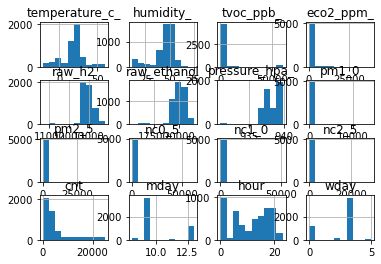

In [18]:
train_X.hist()
plt.show()

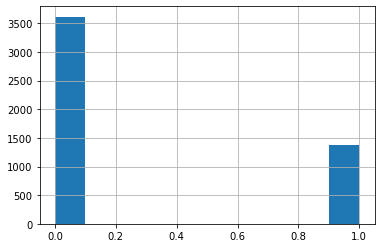

In [20]:
train_y.hist()
plt.show()

# The target classes are imbalanced, positive fire alarm cases are a little less than half of that of no alarm

# Let's balance the data by carrying out minority oversampling

In [22]:
sm = SMOTE()
X, y=sm.fit_resample(train_X, train_y)

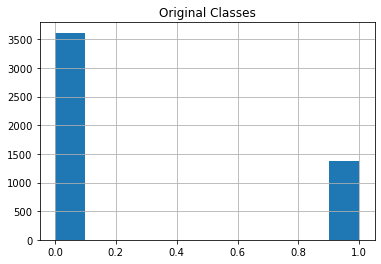

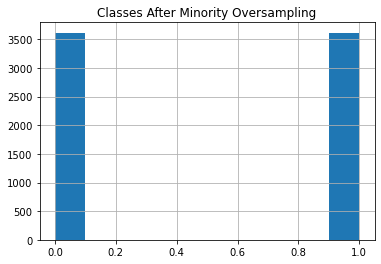

In [29]:
train_y.hist()
plt.title('Original Classes')
plt.show()
y.hist()
plt.title('Classes After Minority Oversampling')
plt.show()

# Train Test Split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Cross Validation for model selection

# Define the models for classification

In [39]:
models = {'LOG': LogisticRegression(max_iter=500, solver='liblinear'),
         'LDA': LinearDiscriminantAnalysis(),
         'KNN': KNeighborsClassifier(),
         'GNB': GaussianNB(),
         'DCT': DecisionTreeClassifier(),
         'SVM': SVC(),
          'RFC': RandomForestClassifier(),
          'ADA': AdaBoostClassifier(),
         'XGB': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        }

# Evaluate each model in turn using cross validation score on the training data. Metrics: Accuracy, Precision, Recall, F1 Score

In [42]:
for name, model in models.items():
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=['accuracy', 'precision', 'recall', 'f1'])
    print(f"{name}: Acc: {cv_results['test_accuracy'].mean():.3f},\
Prec: {cv_results['test_precision'].mean():.3f}, Rec: {cv_results['test_recall'].mean():.3f}, \
F1: {cv_results['test_f1'].mean():.3f}")

LOG: Acc: 0.990,Prec: 0.998, Rec: 0.982, F1: 0.990
LDA: Acc: 0.981,Prec: 0.996, Rec: 0.966, F1: 0.980
KNN: Acc: 0.998,Prec: 0.998, Rec: 0.998, F1: 0.998
GNB: Acc: 0.808,Prec: 0.732, Rec: 0.972, F1: 0.835
DCT: Acc: 0.999,Prec: 0.999, Rec: 0.999, F1: 0.999
SVM: Acc: 0.951,Prec: 0.988, Rec: 0.913, F1: 0.949
RFC: Acc: 1.000,Prec: 1.000, Rec: 1.000, F1: 1.000
ADA: Acc: 1.000,Prec: 1.000, Rec: 0.999, F1: 1.000
XGB: Acc: 0.999,Prec: 0.999, Rec: 1.000, F1: 0.999


# Default Random Forest Classifier is giving the best result with max performance. We will use this for predictions

In [55]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(f'Acc: {acc(y_test, preds):0.4f}, Prec: {ps(y_test, preds):0.4f},\
Rec; {rs(y_test, preds):0.4f}, F1: {f1(y_test, preds):0.4f}')

Acc: 1.0000, Prec: 1.0000,Rec; 1.0000, F1: 1.0000


# Confusion Matrix

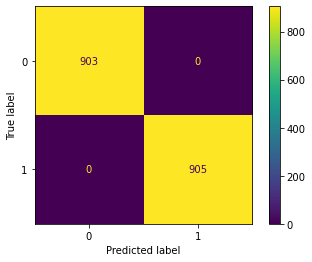

In [49]:
cm.from_predictions(y_test, preds)
plt.show()

# Classification Report

In [52]:
print(cr(y_test,preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       903
           1       1.00      1.00      1.00       905

    accuracy                           1.00      1808
   macro avg       1.00      1.00      1.00      1808
weighted avg       1.00      1.00      1.00      1808



# Feature Importances

<AxesSubplot:title={'center':'Feature Importances'}, ylabel='FN'>

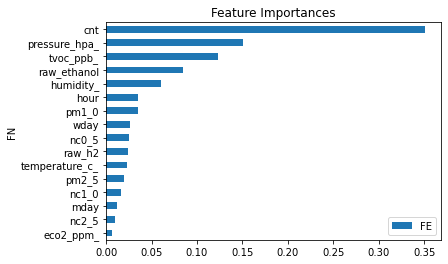

In [57]:
ax = pd.DataFrame(sorted(list(zip(model.feature_importances_, model.feature_names_in_)), 
                        key=lambda x:x[0]), columns=['FE', 'FN'])
ax.set_index('FN', inplace=True)
ax.plot(kind='barh', title='Feature Importances')

# Predictions

In [58]:
final_preds = pd.DataFrame(model.predict(final_X), columns=['Fire Alarm'])
final_preds.to_csv('/home/sandeep/Development/Datasets/Climate/dphi_ds89_smoke_detection/submission/sub4.csv', 
                   index=False)